Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
Train Fraud Cases: 344
Test Fraud Cases: 148
After SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.21      0.24      0.23       148

    accuracy                           1.00     85443
   macro avg       0.60      0.62      0.61     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.6208302504978745

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

AUC-ROC: 0.9659891030018235

Random Forest Results:
           

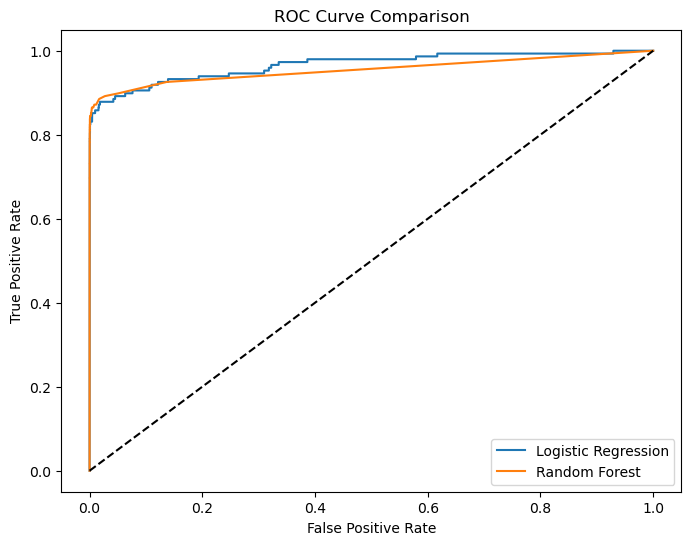

In [5]:
# Fraud Detection System
# Author: [ARNAB BAG]
# Goal: Detect fraudulent transactions in financial data

# ===============================
# 1. Import Libraries
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# ===============================
# 2. Load Dataset
# ===============================
# Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
print(df["Class"].value_counts())

# ===============================
# 3. Data Preprocessing
# ===============================
# Scale Time & Amount (others already scaled via PCA)
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["Time"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))

# Split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train Fraud Cases:", sum(y_train))
print("Test Fraud Cases:", sum(y_test))

# ===============================
# 4. Handle Class Imbalance (SMOTE)
# ===============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

# ===============================
# 5. Model 1 - Isolation Forest (Anomaly Detection)
# ===============================
iso_forest = IsolationForest(contamination=0.002, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_test)

# IsolationForest outputs: -1 = anomaly, 1 = normal → convert
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("\nIsolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_iso))

# ===============================
# 6. Model 2 - Logistic Regression (Supervised)
# ===============================
lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

# ===============================
# 7. Model 3 - Random Forest Classifier
# ===============================
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# ===============================
# 8. ROC Curve Comparison
# ===============================
plt.figure(figsize=(8,6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.plot([0,1], [0,1], 'k--')  # Random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
